## Preparing data for our model

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import requests

# get the directory of the current file
current_dir_win = os.path.dirname(os.path.realpath('__file__'))
current_dir_linux = current_dir_win.replace('\\', '/')

# print how many gpu's are available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
def view_random_images(target_dir, num_images=4):
    target_folder = target_dir
    random_images = random.sample(os.listdir(target_folder), 4)
    fig, axes = plt.subplots(1, 4, figsize=(10, 10))
    axes = axes.flatten()
    for img, ax in zip(random_images, axes):
        img = mpimg.imread(target_folder + "/" + img)
        ax.imshow(img)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

In [20]:
def load_and_prep_img(filename, img_shape=224):
  
  img = tf.io.read_file(filename)
  # Decode readed file into a tensor
  img = tf.image.decode_image(img)
  # If image is not square resize it to square  
  img = tf.image.resize(img, [img_shape, img_shape])

  # check if the image is grayscale and if it is convert it to rgb
  if img.shape[2] == 1:
    img = tf.image.grayscale_to_rgb(img)
    # Reshape the dimensions on image (3, 224, 224) -> (224, 224, 3)
    
    # Rescale the image
    img = img/255
    return tf.squeeze(img)

  # Rescale the image
  img = img/255

  return img

In [3]:
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

In [4]:
all_labels = pd.read_csv(f"{current_dir_linux}/data/train_df.csv")

len(all_labels)

111863

In [5]:
# get all column names of all_labels drop: "Image Index", "Patient ID", "FilePath"
label_names = all_labels.columns.drop(["Image Index", "Patient ID", "FilePath"])

label_names

Index(['Cardiomegaly', 'Emphysema', 'Effusion', 'No Finding', 'Hernia',
       'Infiltration', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax',
       'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema',
       'Consolidation'],
      dtype='object')

In [6]:
all_labels.head()

,Image Index,Patient ID,Cardiomegaly,Emphysema,Effusion,No Finding,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation,FilePath
0,00000001_000.png,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000001_000.png
1,00000001_001.png,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000001_001.png
2,00000001_002.png,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000001_002.png
3,00000002_000.png,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000002_000.png
4,00000003_000.png,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000003_000.png


In [7]:
all_labels["FilePath"][0]

'../input/data/images_001/images/00000001_000.png'

In [8]:
def add_path_to_labels(labels_all):
    all_labels_w_path = labels_all.copy()
    # loop through all labels filepaths and delete first 8 characters and replace them with current_dir_linux
    for i in range(len(all_labels_w_path)):
        all_labels_w_path["FilePath"][i] = current_dir_linux + all_labels_w_path["FilePath"][i][8:]
    return all_labels_w_path

In [9]:
all_labels_w_path = add_path_to_labels(all_labels)

C:\Users\pc\AppData\Local\Temp\ipykernel_23616\289152386.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_labels_w_path["FilePath"][i] = current_dir_linux + all_labels_w_path["FilePath"][i][8:]


In [10]:
all_labels_w_path.iloc[0]["FilePath"]

'H:/Programming/Machine_Learning/Xray_Detection/data/images_001/images/00000001_000.png'

In [11]:
# train test split with random state 42
from sklearn.model_selection import train_test_split
train_labels, test_labels = train_test_split(all_labels_w_path, test_size=0.2, random_state=42)

In [12]:
len(train_labels), len(test_labels)

(89490, 22373)

## Creating a data loader (preparing the data for the model)

In [13]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,samplewise_center=True, samplewise_std_normalization= True)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, samplewise_center=True, samplewise_std_normalization= True)


train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_labels,
    directory=None,
    x_col="FilePath",
    y_col=label_names,
    target_size=(224, 224),
    batch_size=32,
    class_mode="raw",
    shuffle=False,
    seed=42,
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_labels,
    directory=None,
    x_col="FilePath",
    y_col=label_names,
    target_size=(224, 224),
    batch_size=32,
    class_mode="raw",
    shuffle=False,
    seed=42,
)

Found 89490 validated image filenames.
Found 22373 validated image filenames.


## The Model 1: Just a model

In [ ]:
from keras import layers
from keras.applications.mobilenet import MobileNet

base_mobilenet_model = MobileNet(input_shape =  (224, 224, 3), 
                                include_top = False,
                                weights = None)

model_1 = tf.keras.models.Sequential([
    base_mobilenet_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(512),
    layers.Dropout(0.5),

    tf.keras.layers.Dense(15, activation="sigmoid")
], name="model_001")

model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy", "mae"])

model_1.fit(train_generator,
            epochs=1,
            steps_per_epoch=len(train_generator),
            validation_data=test_generator,
            validation_steps=len(test_generator),
            callbacks=[create_model_checkpoint(model_name="model_1_1_epoch_001")])

In [15]:
save_as = "model_1_003.h5"
model_1.save(f"{current_dir_linux}/models/saved_models/{save_as}")

In [167]:
model_1 = tf.keras.models.load_model(f"{current_dir_linux}/models/saved_models/model_1_002.h5")

In [16]:
model_1.evaluate(test_generator)

700/700 [==============================] - 456s 652ms/step - loss: 0.1899 - binary_accuracy: 0.9305 - mae: 0.1111


[0.1899431347846985, 0.9305112361907959, 0.11114640533924103]

1/1 [==============================] - 0s 15ms/step
[[0.00757121 0.04868949 0.06837265 0.49123168 0.00149405 0.19845168
  0.10990751 0.09676814 0.09502273 0.05950095 0.03971642 0.02117198
  0.01920613 0.02776903 0.07604959]]


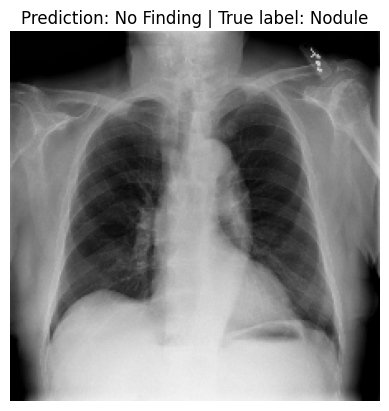

In [226]:
# get an random int between 0 and the length of the test dataset
random_index = random.randint(0, len(all_labels_w_path))
# get an random image from test dataset
test_image = load_and_prep_img(all_labels_w_path.iloc[random_index]["FilePath"])

prediction = model_1.predict(tf.expand_dims(test_image, axis=0))
print(prediction)
prediction_label = label_names[tf.argmax(tf.squeeze(prediction)).numpy()]

# get the true lables of the test image
true_label = all_labels_w_path.iloc[random_index][label_names].to_numpy().argmax()

# plot the image
plt.imshow(test_image)
plt.title(f"Prediction: {prediction_label} | True label: {label_names[true_label]}")
plt.axis(False);